In [27]:
using DrWatson
using DataFrames
using HDF5

┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1278


In [139]:
datapath = "/Users/mr/Desktop/2020-10-16"

"/Users/mr/Desktop/2020-10-16"

In [23]:
records = map(readdir(datapath)) do fname
    prefix, params, suffix = parse_savename(fname)
    params = DataFrame(params)
    params["filename"] = fname
    params
end
df = vcat(records...)
sort!(df, [:duration, :N])

,N,duration,num_responses,filename
,Int64,Int64,Int64,String
1,1,50,250,N=1_duration=50_num_responses=250.hdf5
2,2,50,250,N=2_duration=50_num_responses=250.hdf5
3,3,50,250,N=3_duration=50_num_responses=250.hdf5
4,4,50,250,N=4_duration=50_num_responses=250.hdf5
5,5,50,250,N=5_duration=50_num_responses=250.hdf5
6,6,50,250,N=6_duration=50_num_responses=250.hdf5
7,7,50,250,N=7_duration=50_num_responses=250.hdf5
8,8,50,250,N=8_duration=50_num_responses=250.hdf5
9,9,50,250,N=9_duration=50_num_responses=250.hdf5


In [145]:
me_merged = DataFrame()
ce_merged = DataFrame()
for (duration, group) in pairs(groupby(df, :duration))
    local me = DataFrame()
    local ce = DataFrame()
    for fname in group.filename
        h5open(joinpath(datapath, fname)) do h5f
            dict = DataFrame()
            for obj in h5f["marginal_entropy"]
                dict[name(obj)] = read(obj)
            end
            me = vcat(me, dict; cols=:union)
            
            dict = DataFrame()
            for obj in h5f["conditional_entropy"]
                dict[name(obj)] = read(obj)
            end
            ce = vcat(ce, dict; cols=:union)
        end
    end
    me[:duration] = duration
    ce[:duration] = duration
    me_merged = vcat(me_merged, me; cols=:union)
    ce_merged = vcat(ce_merged, ce; cols=:union)
end

In [169]:
me_merged

,/marginal_entropy/GcTime,/marginal_entropy/Sample,/marginal_entropy/TimeElapsed
,Float64,Float64,Float64
1,0.230496,86.3901,6.72468
2,0.194982,78.8312,4.89478
3,0.217746,92.3854,6.28945
4,0.212916,88.2382,5.90506
5,0.534858,78.4186,5.22496
6,0.127338,85.2199,5.42988
7,0.124016,78.9342,4.8205
8,0.121588,92.0302,5.81954
9,0.114203,92.7158,5.97938


In [167]:
save(joinpath(datapath, "me.csv"), me_merged)
save(joinpath(datapath, "ce.csv"), ce_merged)

In [175]:
me_merged = load(joinpath(datapath, "me.csv"))

LoadError: ArgumentError: No file exists at given path: /Users/mr/Desktop/2020-10-16/me.csv

In [131]:
for (name, value) in zip(names(me_merged[1]), eachcol(me_merged[1]))
    @show name value
#     group[name] = value
end

name = "/marginal_entropy/GcTime"
value = [0.230496395, 0.194981818, 0.217745654, 0.212916106, 0.534858343, 0.127337924, 0.124016114, 0.121588283, 0.114203434, 0.141158235, 0.116301801, 0.145011734, 0.170157076, 0.198933662, 0.179477986, 0.169443054, 0.698385483, 0.186948528, 0.196878465, 0.179097647, 0.20520956, 0.178368417, 0.190327311, 0.209696345, 0.169802561, 0.165694442, 0.154421066, 0.180778324, 0.807189045, 0.222173189, 0.225695391, 0.156933471, 0.141789807, 0.173085429, 0.151873862, 0.136062664, 0.139497848, 0.138938091, 0.138398856, 0.124597872, 0.541056321, 0.164983186, 0.164131197, 0.145419119, 0.126725156, 0.134659545, 0.128032621, 0.136387315, 0.12314426, 0.135311725, 0.116911238, 0.131525905, 0.492806881, 0.143342828, 0.153194911, 0.137077566, 0.128610414, 0.128913669, 0.140440691, 0.128166503, 0.132257089, 0.127691764, 0.141075975, 0.114418878, 0.508580459, 0.144806046, 0.145836537, 0.136694333, 0.128820781, 0.137780703, 0.129645097, 0.135870217, 0.122590985, 0.14023152

Excessive output truncated after 524330 bytes.

In [126]:
h5open(joinpath(datapath, "merged.hdf5"), "w") do file
    
end

"/Users/mr/Desktop/2020-10-16/merged.hdf5"

In [172]:
using Statistics

me = map(me_merged) do df
    mean(df["/marginal_entropy/Sample"])
end

ce = map(ce_merged) do df
    mean(df["/conditional_entropy/Sample"])
end

me_var = map(me_merged) do df
    var(df["/marginal_entropy/Sample"]) / (length(df["/marginal_entropy/Sample"]) - 1)
end

ce_var = map(ce_merged) do df
    var(df["/conditional_entropy/Sample"]) / (length(df["/conditional_entropy/Sample"]) - 1)
end

durations = unique(df.duration)

LoadError: AbstractDataFrame is not iterable. Use eachrow(df) to get a row iterator or eachcol(df) to get a column iterator

In [173]:
error = sqrt.(me_var + ce_var)

6-element Array{Float64,1}:
 0.013634801863453661
 0.02790772969946123
 0.04327537181335837
 0.05877499082225514
 0.07455740809735391
 0.08867443641680851

In [174]:
using Plots

p1 = plot(durations, [(me - ce), 0.00183 .* durations], yerr=[error, zeros(size(error))]', ylim=(0, :auto), xlim=(0, 550), legend=:bottomright)

LoadError: MethodError: no method matching -(::DataFrame, ::DataFrame)
Closest candidates are:
  -(!Matched::Array{DoubleFloats.DoubleFloat{T},1}, ::T) where T at /Users/mr/.julia/packages/DoubleFloats/s9LZK/src/extras/misc.jl:56
  -(!Matched::Array{DoubleFloats.DoubleFloat{T},2}, ::T) where T at /Users/mr/.julia/packages/DoubleFloats/s9LZK/src/extras/misc.jl:62
  -(!Matched::DataValues.DataValue{T1}, ::T2) where {T1, T2} at /Users/mr/.julia/packages/DataValues/N7oeL/src/scalar/operations.jl:65
  ...

In [170]:
3

3

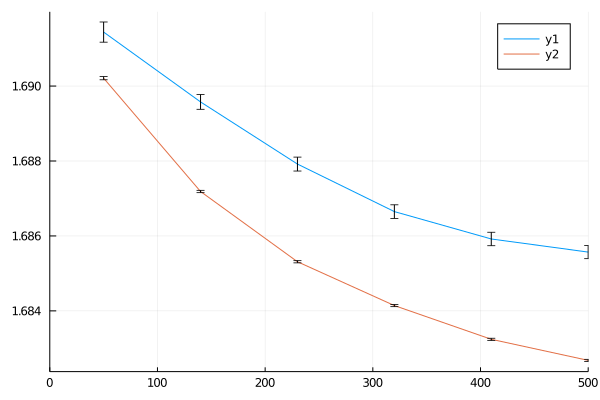

In [125]:
plot(durations, [me ./ durations, ce ./ durations], yerr=[sqrt.(me_var) ./ durations, sqrt.(ce_var) ./ durations]', xlim=(0, :auto))

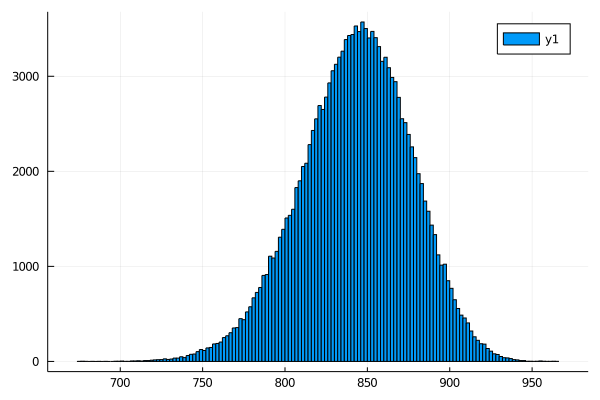

In [99]:
histogram(me_merged[end]["/marginal_entropy/Sample"])

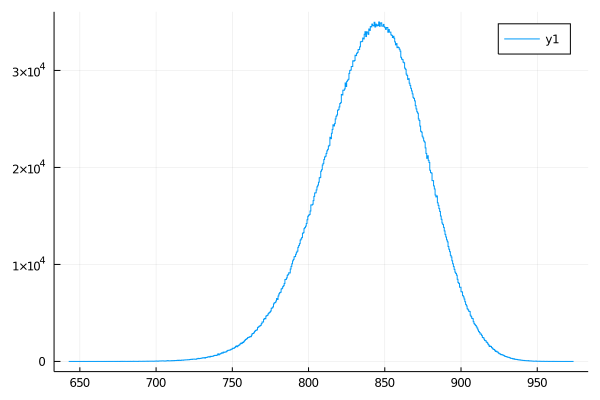

In [100]:
histogram(ce_merged[end]["/conditional_entropy/Sample"])